# Bank Customer Churn EDA

Exploratory analysis of the `Churn_Modelling.csv` dataset to surface feature distributions, churn drivers, and data quality concerns.

In [1]:
from pathlib import Path

import numpy as np
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

try:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

DATA_PATH = Path("../../data/raw/bank_churn/Churn_Modelling.csv").resolve()
DATA_PATH

PosixPath('/Users/ivy/Desktop/project/fusionguard-analytics/data/raw/bank_churn/Churn_Modelling.csv')

In [2]:
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_shape = df.shape
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print("Shape:", df_shape)
print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))
df[numeric_cols].head()

Shape: (10000, 14)
Numeric columns: 11
Categorical columns: 3


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0


In [4]:
numeric_summary = df[numeric_cols].describe().T
numeric_summary["skew"] = df[numeric_cols].skew()
numeric_summary["iqr"] = numeric_summary["75%"] - numeric_summary["25%"]
numeric_summary.head()

,count,mean,std,min,25%,50%,75%,max,skew,iqr
RowNumber,10000.0,5.000500e+03,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0,0.000000,4999.5
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0,0.001149,124705.5
CreditScore,10000.0,6.505288e+02,96.653299,350.0,584.00,652.0,718.00,850.0,-0.071607,134.0
Age,10000.0,3.892180e+01,10.487806,18.0,32.00,37.0,44.00,92.0,1.011320,12.0
Tenure,10000.0,5.012800e+00,2.892174,0.0,3.00,5.0,7.00,10.0,0.010991,4.0


In [5]:
skewness = df[numeric_cols].skew().sort_values(key=lambda s: s.abs(), ascending=False)
skewness.head(10)

Exited             1.471611
Age                1.011320
HasCrCard         -0.901812
NumOfProducts      0.745568
Balance           -0.141109
CreditScore       -0.071607
IsActiveMember    -0.060437
Tenure             0.010991
EstimatedSalary    0.002085
CustomerId         0.001149
dtype: float64

In [6]:
missing = (df.isna().sum() / len(df)).sort_values(ascending=False)
if missing.eq(0).all():
    print("No missing values detected.")
else:
    missing[missing > 0]

No missing values detected.


In [7]:
churn_counts = df["Exited"].value_counts().rename({0: "Retained", 1: "Churned"})
churn_share = (churn_counts / churn_counts.sum()).sort_values(ascending=False)
display(pd.DataFrame({"count": churn_counts, "share": churn_share}))


,count,share
Exited,,
Retained,7963,0.7963
Churned,2037,0.2037


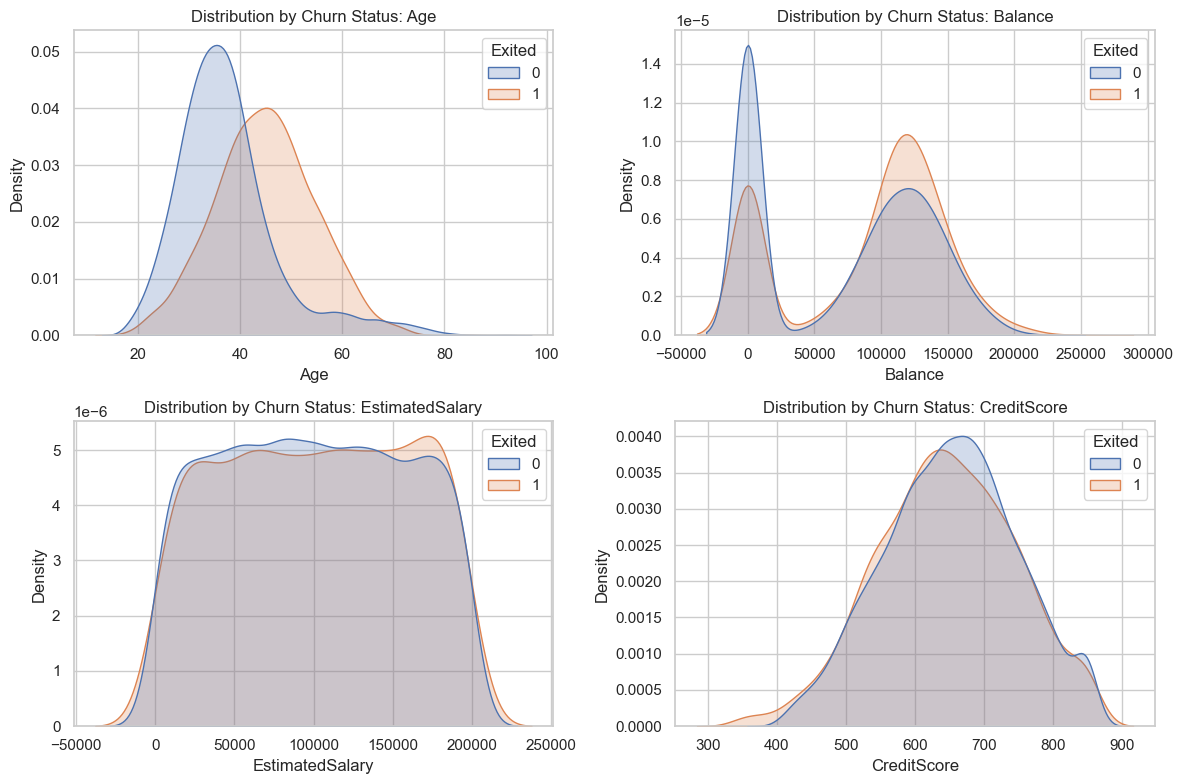

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
selected_features = ['Age', 'Balance', 'EstimatedSalary', 'CreditScore']

for ax, feature in zip(axes.flatten(), selected_features):
    sns.kdeplot(data=df, x=feature, hue='Exited', common_norm=False, ax=ax, fill=True)
    ax.set_title(f'Distribution by Churn Status: {feature}')

plt.tight_layout()
plt.show()

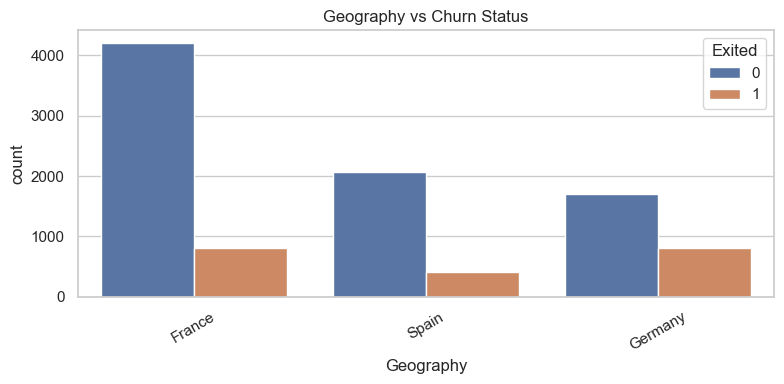

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Geography', hue='Exited')
plt.title('Geography vs Churn Status')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Candidate Data Quality Checks

- `CustomerId` must be unique.
- `Exited` should only take {0, 1}.
- No missing values in mandatory demographic fields.
- Credit score, balance, and salary should remain within observed realistic ranges.
- Categorical domains (`Geography`, `Gender`) consistent with training taxonomy.